In [1]:
# Link to bucket: https://s3.console.aws.amazon.com/s3/buckets/macs30123-bills?region=us-east-1&tab=objects

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1639090373335_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
#install necessary packages
sc.install_pypi_package("boto3") # use boto3 to see book data in S3 bucket
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")
sc.install_pypi_package("dask") #install dask as well
sc.install_pypi_package("textblob") #this is used to conduct sentiment analysis for added feature columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/d7/24/4b70d13b553f7ca14efaa652f5b61e8a1fc63d5a98a0b4eed74eca5c9a16/boto3-1.20.23-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ab/84/fc3717a7b7f0f6bb08af593127171f08e3e0087c197922da09c01bfe7c3a/s3transfer-0.5.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/06/75/72b9236e2ff5ff7d24d1a04dae90cc5974f1cb830ddfe61ba8a18df4664d/botocore-1.23.23-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/af/f4/524415c0744552cce7d8bf3669af78e8a069514405ea4fcbd0cc44733744/urllib3-1.26.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/36/7a/87837f39d0296e723bb9b62bbb257d0355c7f6128853c78955f57342a56d/python_dateutil-2.8.2-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/4a/6a/94b219b8ea0f2d580169e85ed1edc0163743f55aaeca8a44c2e8fc1e344e/pandas-1.0.3-cp37-cp37m-manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.

In [3]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dask import dataframe as dd
from textblob import TextBlob
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from io import StringIO

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
s3 = boto3.client('s3', region_name='us-east-1',)

response = s3.list_objects(Bucket='macs30123-bills')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
data_congress = s3.get_object(Bucket="macs30123-bills", Key="data_congress_breakdown.csv")
data_congress = data_congress['Body'].read()
data_congress = data_congress.decode('utf-8')

df_congress = pd.read_csv(StringIO(data_congress))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
df_congress = df_congress[['Congress (years)', '# of House Seats', 'Democrats', 'Republicans',
       'Other', '% Democrat', '% Republican']]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
df_congress

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     Congress (years)  # of House Seats  ...  % Democrat  % Republican
0   102 (1991 - 1993)             435.0  ...   61.379310      0.383908
1   103 (1993 - 1995)             435.0  ...   59.310345      0.404598
2   104 (1995 - 1997)             435.0  ...   46.896552      0.528736
3   105 (1997 - 1999)             435.0  ...   47.586207      0.519540
4   106 (1999 - 2001)             435.0  ...   48.505747      0.512644
5   107 (2001 - 2003)             435.0  ...   48.735632      0.508046
6   108 (2003 - 2005)             435.0  ...   47.126437      0.526437
7   109 (2005 - 2007)             435.0  ...   46.206897      0.535632
8   110 (2007 - 2009)             435.0  ...   53.563218      0.464368
9   111 (2009 - 2011)             435.0  ...   59.080460      0.409195
10  112 (2011 - 2013)             435.0  ...   44.367816      0.556322
11  113 (2013 - 2015)             435.0  ...   46.206897      0.537931
12  114 (2015 - 2017)             435.0  ...   43.218391      0.567816
13  11

In [8]:
df_congress['% Republican'] = df_congress['% Republican'] * 100

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
df_congress['Congress (years)'] = df_congress['Congress (years)'].astype(str)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
df_congress['congress'] = df_congress['Congress (years)'].apply(lambda txt: txt.split(' ', 1)[0])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

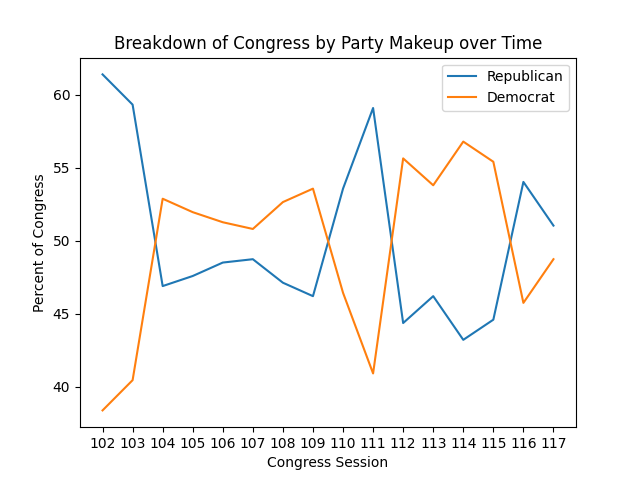

In [11]:
#View congress party makeup over time
plt.close() # Close previous plots; otherwise, will just overwrite and display again

sns.lineplot(x='congress', y='% Democrat', data=df_congress)
sns.lineplot(x='congress', y='% Republican', data=df_congress)
plt.title('Breakdown of Congress by Party Makeup over Time')
plt.xlabel('Congress Session')
plt.ylabel('Percent of Congress')
plt.legend(['Republican', 'Democrat'])
%matplot plt

In [12]:
#read in the bills dataset from our s3 bucket
df_bills = s3.get_object(Bucket="macs30123-bills", Key="data_bills.csv")
df_bills = df_bills['Body'].read()
df_bills = df_bills.decode('utf-8')

df_bills = pd.read_csv(StringIO(df_bills))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
df_congress = df_congress.dropna()
df_congress['congress'] = df_congress['congress'].astype(int)
df = df_bills.merge(df_congress, left_on='session', right_on='congress',)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
df = df[df['type'] != 'hres']
df = df[df['type'] != 'sconres'] #remove hres and sconres type bills from our dataset

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
df['type'].unique() #verify that hres and sconres type bills have been removed

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array(['hr', 's'], dtype=object)

Create our binary outcome variable based on whether or not bills have passed through Congress.

In [16]:
df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              Unnamed: 0  session type  ... % Democrat  % Republican  congress
0      BILLS-113hr1000ih      113   hr  ...  46.206897     53.793103       113
1      BILLS-113hr1001ih      113   hr  ...  46.206897     53.793103       113
2      BILLS-113hr1002ih      113   hr  ...  46.206897     53.793103       113
3      BILLS-113hr1003ih      113   hr  ...  46.206897     53.793103       113
4      BILLS-113hr1004ih      113   hr  ...  46.206897     53.793103       113
...                  ...      ...  ...  ...        ...           ...       ...
61716    BILLS-116s998rs      116    s  ...  54.022989     45.747126       116
61717    BILLS-116s999is      116    s  ...  54.022989     45.747126       116
61718    BILLS-116s999rs      116    s  ...  54.022989     45.747126       116
61719     BILLS-116s99is      116    s  ...  54.022989     45.747126       116
61720      BILLS-116s9is      116    s  ...  54.022989     45.747126       116

[58011 rows x 17 columns]

In [17]:
df.groupby(['type', 'session'])['outcome'].count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

type  session
hr    113         7831
      114         9129
      115        10721
      116        11475
s     113         3648
      114         4412
      115         4806
      116         5977
Name: outcome, dtype: int64

In [18]:
df['pass'] = np.where(df['outcome'] == 'enr', 1, 0) #bills with an outcome of enr is considered a pass

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
df = df.drop(['Congress (years)', '# of House Seats', 'Democrats', 'Republicans', 'Other'], axis=1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
df['Unnamed: 0'] = df['Unnamed: 0'].astype(str)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
df['outcome'] = df['outcome'].astype(str)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
#convert our merged dataset that contains all our data into a Spark Dataframe
from pyspark.sql import SparkSession

#create a spark session
sparksesh = SparkSession.builder.master('local[1]').appName('SparkByExamples.com').getOrCreate()

sdf = sparksesh.createDataFrame(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
#view our newly created Spark Dataframe
sdf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-------+----+-------+-------------+-------------+----------+-------------------+--------------------+-----------+------------+--------+----+
|       Unnamed: 0|session|type|outcome|sponsor_count|section_count|word_count|       subjectivity|            polarity| % Democrat|% Republican|congress|pass|
+-----------------+-------+----+-------+-------------+-------------+----------+-------------------+--------------------+-----------+------------+--------+----+
|BILLS-113hr1000ih|    113|  hr|     ih|            1|           10|      5828| 0.3655130309870722| 0.06525710181466382|46.20689655|  53.7931034|     113|   0|
|BILLS-113hr1001ih|    113|  hr|     ih|            3|            1|       482| 0.4160595238095238| 0.08928273809523811|46.20689655|  53.7931034|     113|   0|
|BILLS-113hr1002ih|    113|  hr|     ih|            8|            4|       914| 0.7384660421545669|  0.3741412958626073|46.20689655|  53.7931034|     113|   0|
|BILLS-113hr1003ih|    113|  hr|     ih|

In [24]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# UDF used to convert the column type from a vector to a double type
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

# Converting our column to a vector using VectorAssembler
assembler = VectorAssembler(inputCols=['word_count'],outputCol='word_count_vect')

# Convert vector to scalar using MinMaxScaler
scaler = MinMaxScaler(inputCol='word_count_vect', outputCol='word_count_scaled')

# Create a pipeline from of VectorAssembler and MinMaxScaler
pipeline = Pipeline(stages=[assembler, scaler])

# Fitting pipeline the column word_count to normalise it due to the large degree of variation
sdf = pipeline.fit(sdf).transform(sdf).withColumn('word_count_scaled', unlist('word_count_scaled')).drop('word_count_vect')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
#view new spark dataframe with the scaled word_count column
sdf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-------+----+-------+-------------+-------------+----------+-------------------+--------------------+-----------+------------+--------+----+-----------------+
|       Unnamed: 0|session|type|outcome|sponsor_count|section_count|word_count|       subjectivity|            polarity| % Democrat|% Republican|congress|pass|word_count_scaled|
+-----------------+-------+----+-------+-------------+-------------+----------+-------------------+--------------------+-----------+------------+--------+----+-----------------+
|BILLS-113hr1000ih|    113|  hr|     ih|            1|           10|      5828| 0.3655130309870722| 0.06525710181466382|46.20689655|  53.7931034|     113|   0|            0.006|
|BILLS-113hr1001ih|    113|  hr|     ih|            3|            1|       482| 0.4160595238095238| 0.08928273809523811|46.20689655|  53.7931034|     113|   0|            0.001|
|BILLS-113hr1002ih|    113|  hr|     ih|            8|            4|       914| 0.7384660421545669|  0.3741412

In [26]:
#use vectorassembler to get our features into the form expected by pyspark.ml
from pyspark.ml.feature import VectorAssembler

features = ['sponsor_count', 'section_count', 'word_count_scaled', 'subjectivity', 'polarity', '% Democrat', '% Republican']
assembler = VectorAssembler(inputCols = features, outputCol = 'features')

s_df = assembler.transform(sdf)
s_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-------+----+-------+-------------+-------------+----------+-------------------+--------------------+-----------+------------+--------+----+-----------------+--------------------+
|       Unnamed: 0|session|type|outcome|sponsor_count|section_count|word_count|       subjectivity|            polarity| % Democrat|% Republican|congress|pass|word_count_scaled|            features|
+-----------------+-------+----+-------+-------------+-------------+----------+-------------------+--------------------+-----------+------------+--------+----+-----------------+--------------------+
|BILLS-113hr1000ih|    113|  hr|     ih|            1|           10|      5828| 0.3655130309870722| 0.06525710181466382|46.20689655|  53.7931034|     113|   0|            0.006|[1.0,10.0,0.006,0...|
|BILLS-113hr1001ih|    113|  hr|     ih|            3|            1|       482| 0.4160595238095238| 0.08928273809523811|46.20689655|  53.7931034|     113|   0|            0.001|[3.0,1.0,0.001,0....|
|BILL

In [27]:
#split into training and test datasets
train, test = s_df.randomSplit([0.7, 0.3])

#create and run model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features', labelCol='pass')
model = lr.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
#Summary of Training Data
trainingSummary = model.summary
evaluationSummary = model.evaluate(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Evaluate Model Performance

In [29]:
print('Training AUC: ' + str(trainingSummary.areaUnderROC))
print('Test AUC: ', str(evaluationSummary.areaUnderROC))

print("\nFalse positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))
    
print("\nTraining Accuracy: " + str(trainingSummary.accuracy))
print("Test Accuracy: ", str(evaluationSummary.accuracy))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training AUC: 0.9352028352820378
Test AUC:  0.9416825338637974

False positive rate by label (Training):
label 0: 0.988421052631579
label 1: 0.0004279421019509125

True positive rate by label (Training):
label 0: 0.999572057898049
label 1: 0.011578947368421053

Training Accuracy: 0.9764966195451752
Test Accuracy:  0.9760036917397323

In [30]:
# Obtain ROC curve and send to Pandas for plot
roc_df = evaluationSummary.roc.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

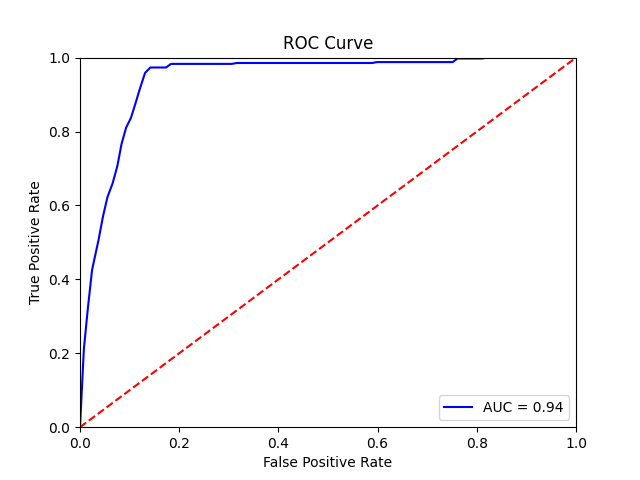

In [31]:
# Close previous plots; otherwise, will just overwrite and display again
plt.close()

plt.plot(roc_df.FPR, roc_df.TPR, 'b', label = 'AUC = %0.2f' % evaluationSummary.areaUnderROC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

%matplot plt

In [32]:
#view feature importances
model.coefficients

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseVector([-2.5434, -0.0101, 42.4217, -5.3419, 3.7875, 0.0321, 0.0366])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

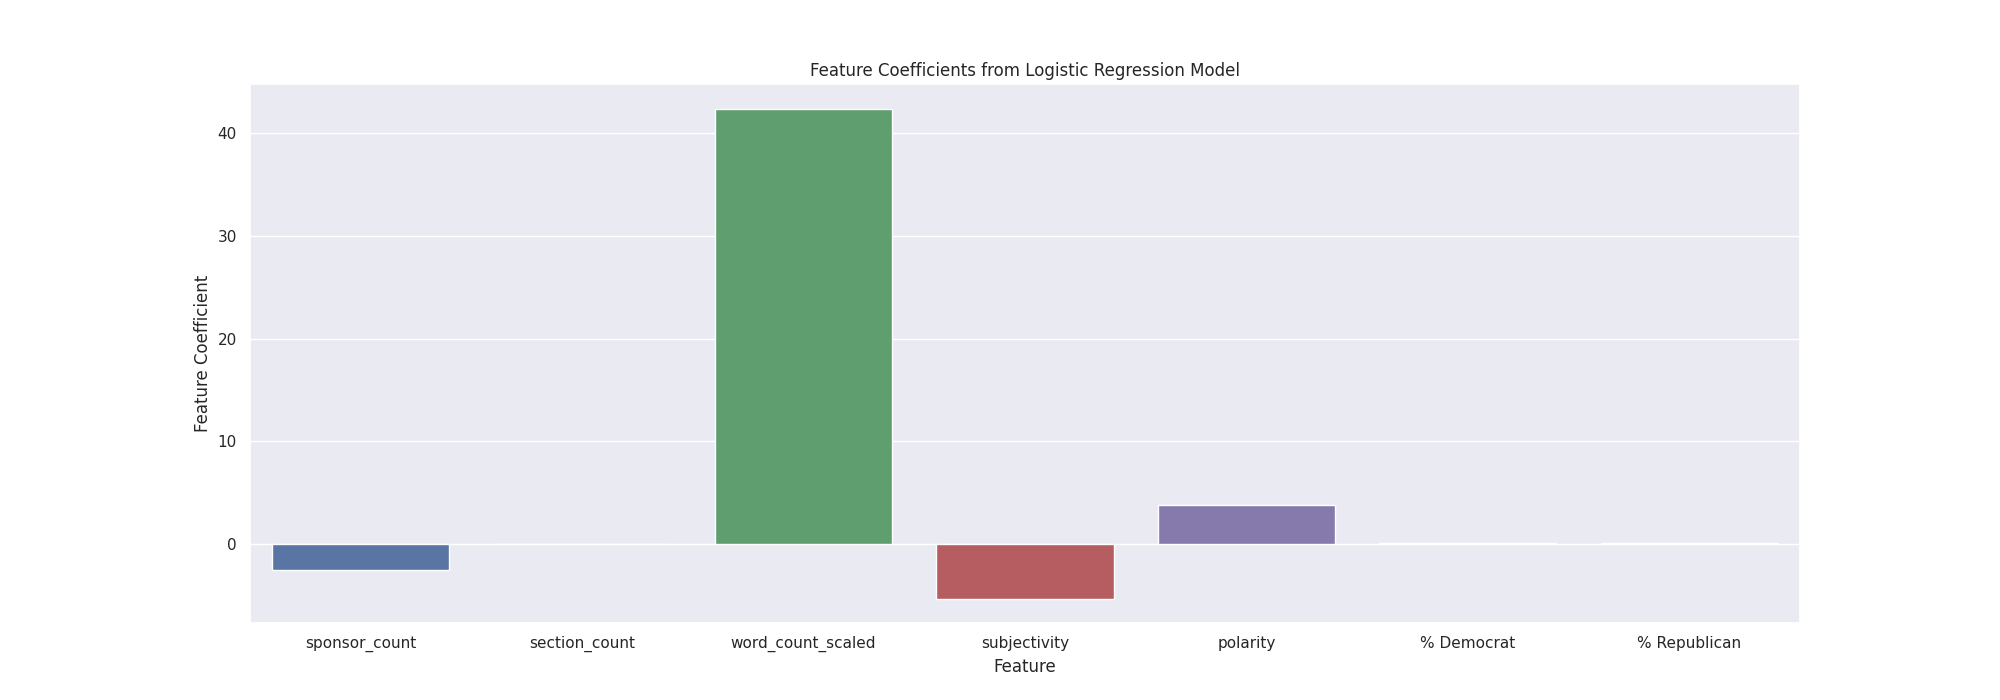

In [33]:
#plot our model features by importance

plt.close() # Close previous plots; otherwise, will just overwrite and display again
sns.set(rc={'figure.figsize':(20, 7)})

sns.barplot(x=features, y= list(model.coefficients))
plt.title('Feature Coefficients from Logistic Regression Model')
plt.xlabel('Feature')
plt.ylabel('Feature Coefficient')
%matplot plt

In [34]:
import pyspark.sql.functions as F
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

predictions = model.transform(test)

#Create a Confusion Matrix to further evaluate model performance

#First create a prediction column and convert to float type, then order by prediction
pred_labels = predictions.select(['prediction','pass']).withColumn('label', F.col('pass').cast(FloatType())).orderBy('prediction')

pred_labels = pred_labels.select(['prediction','label'])

metrics = MulticlassMetrics(pred_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[1.6915e+04 1.0000e+01]
 [4.0600e+02 5.0000e+00]]

In [35]:
cm = metrics.confusionMatrix().toArray()
tp = cm[0][0] #true positives
fn = cm[0][1] #false positives
fp = cm[1][0] #false negatives
tn = cm[1][1] #true negatives

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
#Calculate precision, recall, and accuracy
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print('Precision score for our model is {}'.format(precision))
print('Recall score for our model is {}'.format(recall))
print('The F-score for our model is {}'.format(2*recall*precision/(recall+precision)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Precision score for our model is 0.9765602447895618
Recall score for our model is 0.9994091580502216
The F-score for our model is 0.9878525959236115

In [37]:
p_pred_labels = pred_labels.toPandas() #convert our precition dataframe from spark to pandas

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
from sklearn.metrics import confusion_matrix

#Confusion matrix from pandas df
p_cf = confusion_matrix(p_pred_labels['label'], p_pred_labels['prediction'])

print(p_cf)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
No module named 'sklearn'
Traceback (most recent call last):
ModuleNotFoundError: No module named 'sklearn'



In [39]:
import seaborn as sns

plt.close()

ax = sns.heatmap(p_cf, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix of Logistic Regression Model\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'p_cf' is not defined
Traceback (most recent call last):
NameError: name 'p_cf' is not defined

